In [74]:
# Cell 1 - setup & imports
%matplotlib inline

import math
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)


In [75]:
# Cell 2 automatically discover DB by searching upward (recommended)
from pathlib import Path
from sqlalchemy import create_engine
import pandas as pd

# search upward from cwd
p = Path.cwd()
DB_PATH = None
for _ in range(8):
    candidate = p / "src" / "wafer_data.db"
    if candidate.exists():
        DB_PATH = candidate.resolve()
        break
    p = p.parent

if DB_PATH is None:
    raise FileNotFoundError("could not find src/wafer_data.db in parent folders; check DB location")

print("Using DB path:", DB_PATH)
engine = create_engine(f"sqlite:///{DB_PATH.as_posix()}")

# Read devices table
df = pd.read_sql("SELECT * FROM devices", engine)
wafers = pd.read_sql("SELECT * FROM wafers", engine)

print("devices rows:", len(df))
print("wafers rows:", len(wafers))
display(wafers)
df.head(10)


Using DB path: C:\Users\sahad\Desktop\wafer-ml-project\src\wafer_data.db
devices rows: 6
wafers rows: 5


,id,wafer_name
0,1,W01
1,2,W02
2,3,W10
3,4,W11
4,5,W12


,id,wafer_id,device_name,vth,leakage
0,1,1,DIE001,0.72,1.200000e-09
1,2,1,DIE002,0.69,8.500000e-10
2,3,2,DIE001,0.75,1.500000e-09
3,4,1,DIE001,0.72,1.200000e-09
4,5,1,DIE002,0.69,8.500000e-10
5,6,2,DIE001,0.75,1.500000e-09


In [76]:
# Cell 3 - basic stats
display(df.info())
display(df.describe(include='all'))

# If vth or leakage are strings / contain nulls, try coercion
for col in ['vth', 'leakage']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("Nulls per column:")
print(df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           6 non-null      int64  
 1   wafer_id     6 non-null      int64  
 2   device_name  6 non-null      object 
 3   vth          6 non-null      float64
 4   leakage      6 non-null      float64
dtypes: float64(2), int64(2), object(1)
memory usage: 372.0+ bytes


None

,id,wafer_id,device_name,vth,leakage
count,6.000000,6.000000,6,6.000000,6.000000e+00
unique,NaN,NaN,2,NaN,NaN
top,NaN,NaN,DIE001,NaN,NaN
freq,NaN,NaN,4,NaN,NaN
mean,3.500000,1.333333,NaN,0.720000,1.183333e-09
std,1.870829,0.516398,NaN,0.026833,2.909754e-10
min,1.000000,1.000000,NaN,0.690000,8.500000e-10
25%,2.250000,1.000000,NaN,0.697500,9.375000e-10
50%,3.500000,1.000000,NaN,0.720000,1.200000e-09
75%,4.750000,1.750000,NaN,0.742500,1.425000e-09


Nulls per column:
id             0
wafer_id       0
device_name    0
vth            0
leakage        0
dtype: int64


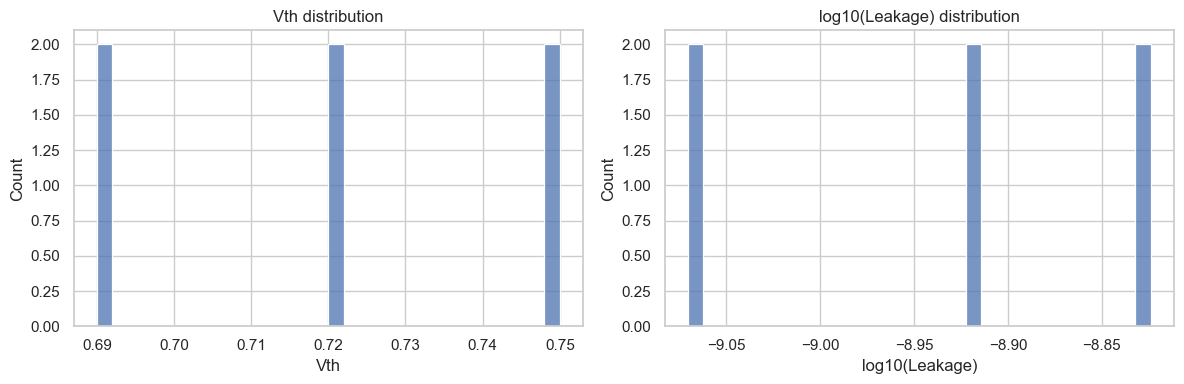

In [77]:
# Cell 4 - histograms
fig, ax = plt.subplots(1, 2, figsize=(12,4))
if 'vth' in df.columns:
    sns.histplot(df['vth'].dropna(), bins=30, ax=ax[0])
    ax[0].set_title("Vth distribution")
    ax[0].set_xlabel("Vth")
else:
    ax[0].text(0.5, 0.5, 'No vth column', ha='center')

if 'leakage' in df.columns:
    # leakage often spans many orders -> use log scale on y axis or log of values
    leakage = df['leakage'].dropna()
    # avoid negative/zero values when taking log
    leakage_pos = leakage[leakage > 0]
    sns.histplot(np.log10(leakage_pos), bins=30, ax=ax[1])
    ax[1].set_title("log10(Leakage) distribution")
    ax[1].set_xlabel("log10(Leakage)")
else:
    ax[1].text(0.5, 0.5, 'No leakage column', ha='center')

plt.tight_layout()


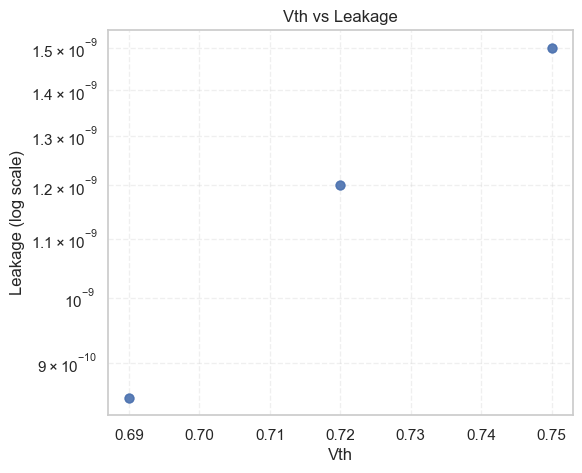

In [78]:
# Cell 5 - scatter plot vth vs leakage
if {'vth','leakage'}.issubset(df.columns):
    plt.figure(figsize=(6,5))
    plot_df = df.dropna(subset=['vth','leakage']).copy()
    # remove non-positive leakages for log scale
    plot_df = plot_df[plot_df['leakage'] > 0]
    plt.scatter(plot_df['vth'], plot_df['leakage'], alpha=0.7, s=40)
    plt.yscale('log')
    plt.xlabel('Vth')
    plt.ylabel('Leakage (log scale)')
    plt.title('Vth vs Leakage')
    plt.grid(True, which='both', ls='--', alpha=0.3)
    plt.show()
else:
    print("Need both 'vth' and 'leakage' to make the scatter plot.")


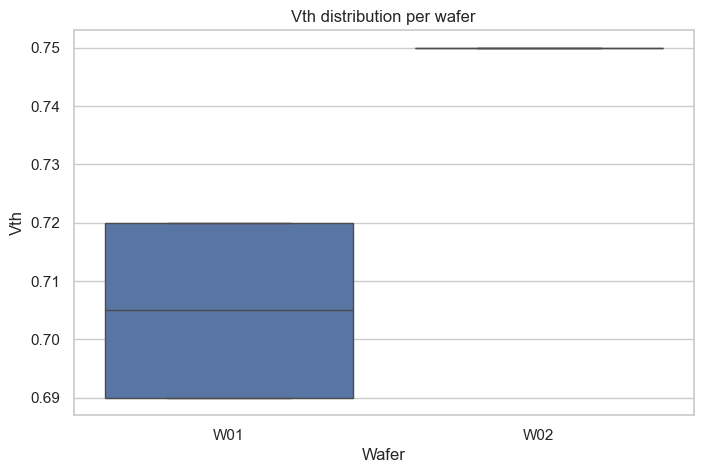

In [79]:
# Cell 6 - boxplot per wafer
if 'vth' in df.columns and 'wafer_id' in df.columns:
    plt.figure(figsize=(8,5))
    # merge wafer name if available
    wafermap = wafers.set_index('id')['wafer_name'].to_dict() if 'id' in wafers.columns else {}
    df['wafer_name'] = df['wafer_id'].map(wafermap).fillna(df['wafer_id'].astype(str))
    sns.boxplot(x='wafer_name', y='vth', data=df)
    plt.title('Vth distribution per wafer')
    plt.xlabel('Wafer')
    plt.ylabel('Vth')
    plt.show()
else:
    print("No wafer_id or vth column found to plot boxplot.")


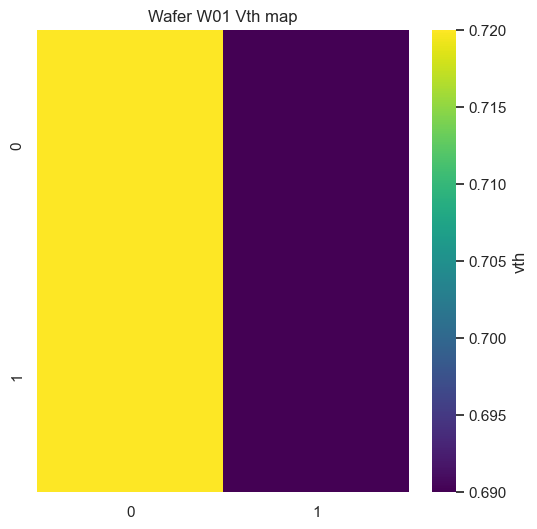

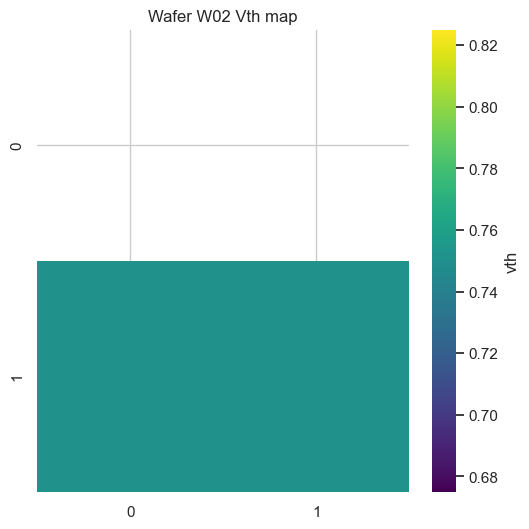

In [80]:
# Cell 7 - wafer map: prefer explicit x,y columns; otherwise create a pseudo-grid
def plot_wafer_map(df_sub, metric_col='vth', title=None):
    plt.figure(figsize=(6,6))
    if {'x','y'}.issubset(df_sub.columns):
        pivot = df_sub.pivot_table(index='y', columns='x', values=metric_col, aggfunc='mean')
        sns.heatmap(pivot[::-1], cmap='viridis', cbar_kws={'label': metric_col})
        plt.title(title or f"{metric_col} wafer map (x,y)")
    else:
        # fallback: create a grid based on count
        n = len(df_sub)
        grid_size = math.ceil(math.sqrt(n))
        vals = df_sub[metric_col].fillna(np.nan).values
        # pad vals to grid_size^2
        pad = grid_size*grid_size - len(vals)
        vals_padded = np.concatenate([vals, np.full(pad, np.nan)])
        matrix = vals_padded.reshape(grid_size, grid_size)
        sns.heatmap(matrix[::-1], cmap='viridis', cbar_kws={'label': metric_col})
        plt.title(title or f"{metric_col} pseudo-wafer map (grid {grid_size}x{grid_size})")
    plt.show()

# run wafer map per wafer
if 'wafer_id' in df.columns and 'vth' in df.columns:
    for wid, group in df.groupby('wafer_id'):
        name = wafers.set_index('id').loc[wid]['wafer_name'] if ('id' in wafers.columns and wid in wafers['id'].values) else str(wid)
        plot_wafer_map(group, metric_col='vth', title=f"Wafer {name} Vth map")
else:
    print("Need wafer_id and vth to draw wafer maps.")


In [81]:
# Cell 8 - write a cleaned copy or save a derived table
cleaned = df.copy()
# example: mark rows with extremely high leakage as suspected anomalies
if 'leakage' in cleaned.columns:
    cleaned['leak_suspect'] = cleaned['leakage'] > (cleaned['leakage'].median() * 100)  # tweak threshold as needed

# write to a new table in the same DB
cleaned.to_sql("devices_cleaned", engine, if_exists="replace", index=False)
print("Wrote devices_cleaned table to DB")


Wrote devices_cleaned table to DB


In [82]:
from sqlalchemy import create_engine
from pathlib import Path

engine = create_engine(f"sqlite:///{DB_PATH.as_posix()}")

df_ml = pd.read_sql("""
SELECT d.*, m.cluster_label, m.is_anomaly, m.anomaly_score
FROM devices d
LEFT JOIN devices_ml m ON d.id = m.id
""", engine)

df_ml


,id,wafer_id,device_name,vth,leakage,cluster_label,is_anomaly,anomaly_score
0,1,1,DIE001,0.72,1.200000e-09,2,0,0.079811
1,2,1,DIE002,0.69,8.500000e-10,1,0,0.000000
2,3,2,DIE001,0.75,1.500000e-09,0,0,0.032406
3,4,1,DIE001,0.72,1.200000e-09,2,0,0.079811
4,5,1,DIE002,0.69,8.500000e-10,1,0,0.000000
5,6,2,DIE001,0.75,1.500000e-09,0,0,0.032406


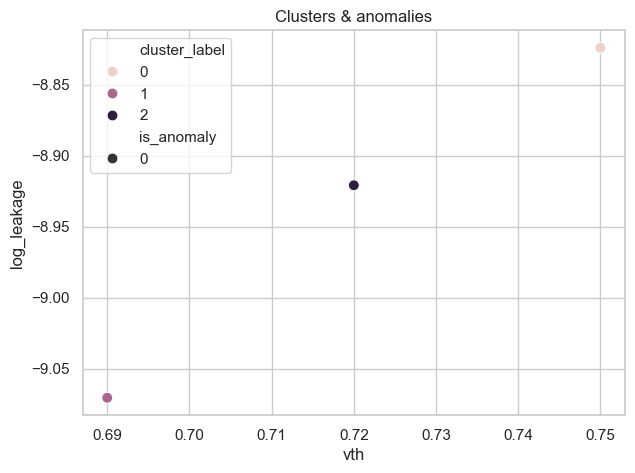

In [83]:
df_ml['log_leakage'] = np.log10(df_ml['leakage'])
sns.scatterplot(data=df_ml, x='vth', y='log_leakage',
                hue='cluster_label', style='is_anomaly', s=60)
plt.title("Clusters & anomalies")
plt.show()


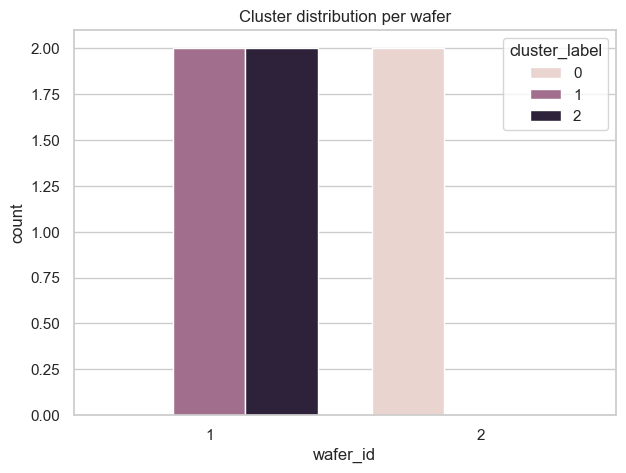

In [84]:
sns.countplot(data=df_ml, x='wafer_id', hue='cluster_label')
plt.title("Cluster distribution per wafer")
plt.show()


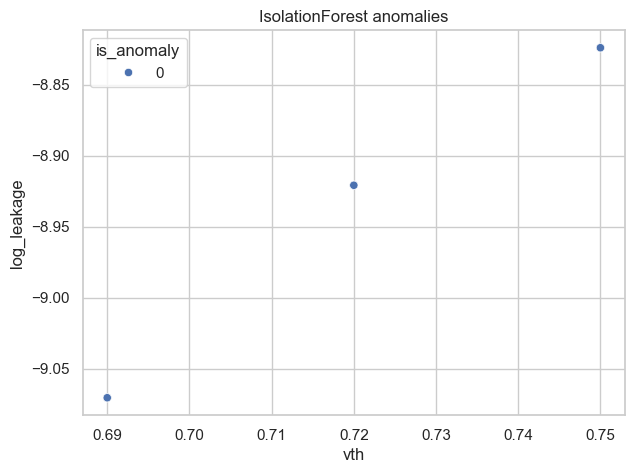

In [85]:
sns.scatterplot(data=df_ml, x='vth', y='log_leakage',
                hue='is_anomaly')
plt.title("IsolationForest anomalies")
plt.show()


In [86]:
df = df.drop_duplicates(subset=['wafer_id','device_name','vth','leakage'])


In [87]:
# load simulated devices
df_sim = pd.read_sql("SELECT * FROM devices_sim", engine)
print("sim rows:", len(df_sim))
df_sim.head()


sim rows: 9000


,wafer_id,device_name,vth,leakage,x,y,is_defect
0,3,DIE0001,0.678718,8.582987e-10,0,0,0
1,3,DIE0002,0.697075,9.182008e-10,0,1,0
2,3,DIE0003,0.699413,1.127601e-09,0,2,0
3,3,DIE0004,0.670915,1.007029e-09,0,3,0
4,3,DIE0005,0.677803,1.073434e-09,0,4,0


In [88]:
df_sim.groupby('wafer_id').size().reset_index(name='count')


,wafer_id,count
0,3,3000
1,4,3000
2,5,3000


In [89]:
df_sim.groupby('wafer_id').size().reset_index(name='count')


,wafer_id,count
0,3,3000
1,4,3000
2,5,3000


In [90]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_wafer_heatmap(df_sub, metric='vth', title=None, cmap='viridis'):
    # pivot table by x,y. if duplicates exist at same x,y use mean
    pivot = df_sub.pivot_table(index='y', columns='x', values=metric, aggfunc='mean')
    # ensure rows are ordered top-to-bottom: reverse y axis (higher y at top)
    plt.figure(figsize=(6,6))
    sns.heatmap(pivot[::-1], cmap=cmap, cbar_kws={'label': metric})
    plt.title(title or f"{metric} wafer map")
    plt.axis('off')
    plt.show()


Wafer id: 3 rows: 3000


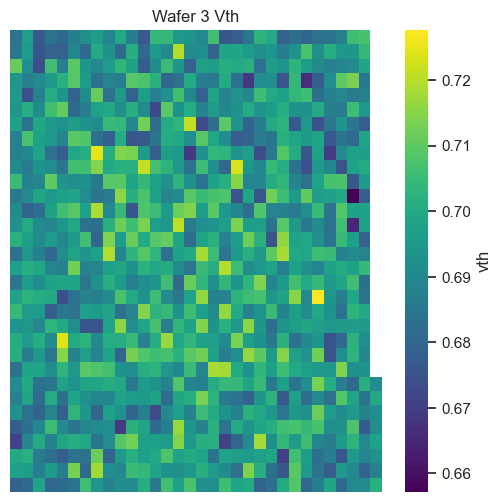

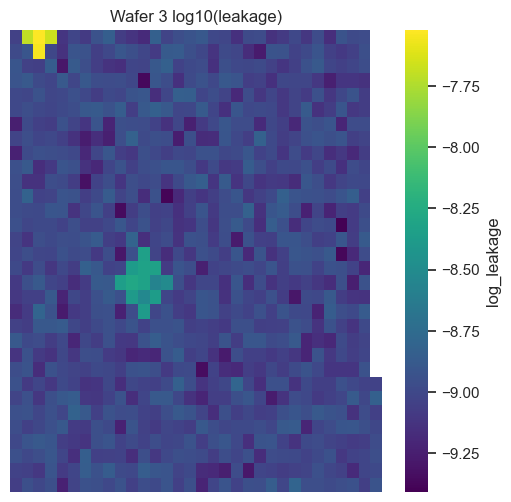

Wafer id: 4 rows: 3000


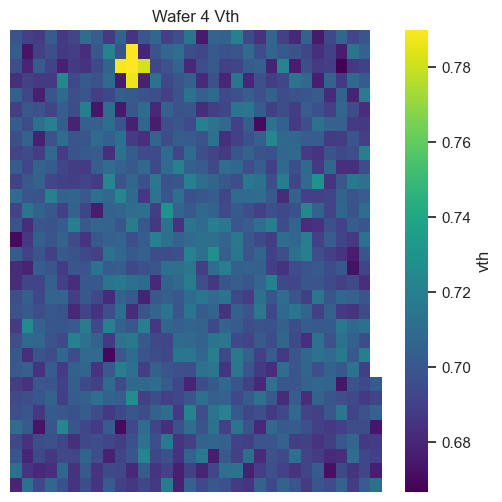

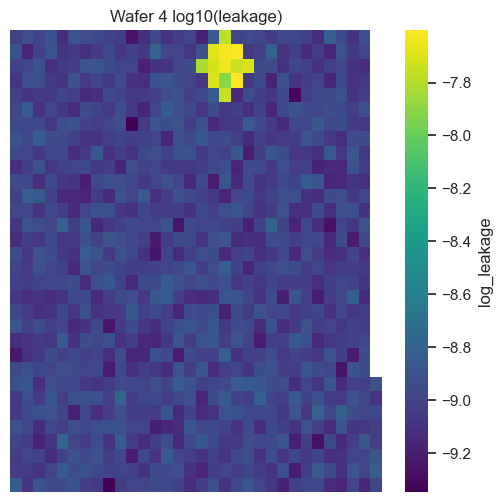

Wafer id: 5 rows: 3000


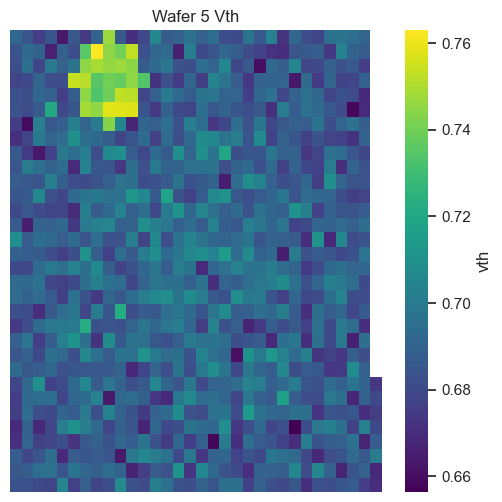

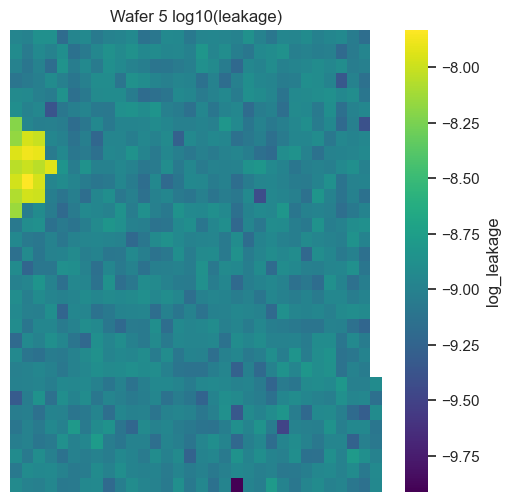

In [91]:
for wid, group in df_sim.groupby('wafer_id'):
    # wafer name (look up wafer table if you want names)
    print("Wafer id:", wid, "rows:", len(group))
    plot_wafer_heatmap(group, metric='vth', title=f"Wafer {wid} Vth")
    group['log_leakage'] = np.log10(group['leakage'].replace(0, np.nan))
    plot_wafer_heatmap(group, metric='log_leakage', title=f"Wafer {wid} log10(leakage)")


In [92]:
# Notebook ML cell — includes radial distance + tuned contamination
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import numpy as np
import pandas as pd

# load simulated devices (if not loaded)
df_sim = pd.read_sql("SELECT * FROM devices_sim", engine)
# merge with existing ML results if you like, but start fresh:
df = df_sim.copy()

# ensure numeric
df['vth'] = pd.to_numeric(df['vth'], errors='coerce')
df['leakage'] = pd.to_numeric(df['leakage'], errors='coerce')
df = df.dropna(subset=['vth','leakage']).reset_index(drop=True)
df = df[df['leakage'] > 0]

# log transform leakage
df['log_leakage'] = np.log10(df['leakage'])

# radial distance (spatial feature)
if {'x','y'}.issubset(df.columns):
    x_mean, y_mean = df['x'].mean(), df['y'].mean()
    df['radial_dist'] = np.sqrt((df['x'] - x_mean)**2 + (df['y'] - y_mean)**2)
else:
    df['radial_dist'] = 0.0

# features to use
features = ['vth','log_leakage','radial_dist']

# scale
scaler = StandardScaler()
Xs = scaler.fit_transform(df[features].values)

# KMeans for segmentation (unchanged)
k = 4
km = KMeans(n_clusters=k, random_state=42, n_init=10)
df['cluster_label'] = km.fit_predict(Xs)

# IsolationForest with tuned contamination
contamination_val = 0.03   # try 0.03; increase to 0.05 for more sensitivity
iso = IsolationForest(n_estimators=200, contamination=contamination_val, random_state=42)
df['anomaly_score'] = iso.fit(Xs).decision_function(Xs)
df['is_anomaly'] = (iso.predict(Xs) == -1).astype(int)

# Save results to DB table devices_sim_ml (replace)
df[['wafer_id','device_name','x','y','vth','leakage','log_leakage','radial_dist','cluster_label','is_anomaly','anomaly_score']].to_sql('devices_sim_ml', engine, if_exists='replace', index=False)

# quick summary and per-wafer reporting
print("Total rows:", len(df))
print("Predicted anomalies:", int(df['is_anomaly'].sum()))
print(df.groupby('wafer_id').agg(true_defects=('is_defect','sum') if 'is_defect' in df.columns else ('device_name','count'),
                                 predicted_anomalies=('is_anomaly','sum')))


Total rows: 9000
Predicted anomalies: 270
          true_defects  predicted_anomalies
wafer_id                                   
3                   51                   63
4                   54                   75
5                  141                  132


In [93]:
for wid, group in df_ml.groupby('wafer_id'):
    print("Wafer", wid, "anomalies:", group['is_anomaly'].sum())
    plt.figure(figsize=(6,6))
    # plot Vth heatmap in background
    plot_wafer_heatmap(group, metric='vth', title=f"Wafer {wid} Vth with clusters (overlay)")
    # overlay cluster scatter (small)
    plt.figure(figsize=(6,6))
    sns.scatterplot(data=group, x='x', y='y', hue='cluster_label', style='is_anomaly', s=12, palette='tab10', alpha=0.8)
    plt.gca().invert_yaxis()
    plt.title(f"Wafer {wid} clusters / anomalies (points)")
    plt.show()


Wafer 1 anomalies: 0


KeyError: 'y'

<Figure size 600x600 with 0 Axes>

Visual overlay: wafer Vth map plus anomaly points

Wafer 3 — total points: 9000, anomalies: 36


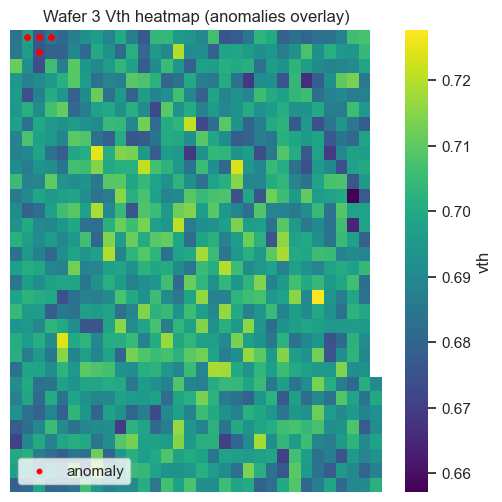

Wafer 4 — total points: 9000, anomalies: 135


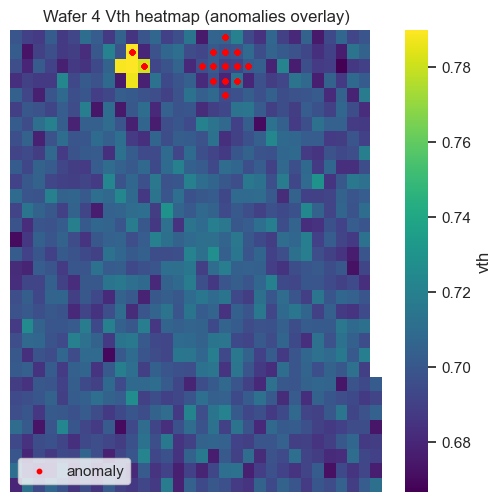

Wafer 5 — total points: 9000, anomalies: 99


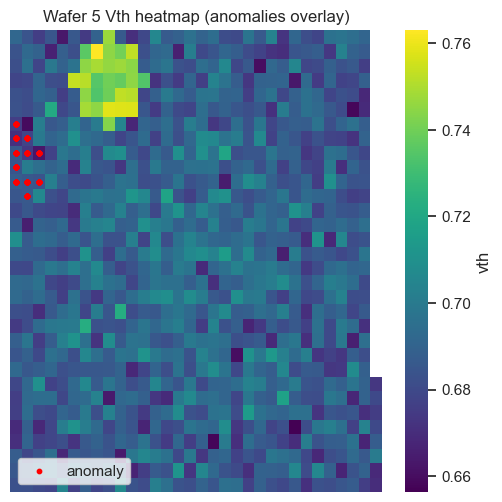

In [ ]:
# overlay anomalies on Vth heatmap (for each wafer)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# assume df_ml is loaded (devices_sim_ml) and df_sim loaded earlier
# if not, run:
# df_ml = pd.read_sql("SELECT * FROM devices_sim_ml", engine)
# df_sim = pd.read_sql("SELECT * FROM devices_sim", engine)

df_ml = pd.read_sql("SELECT * FROM devices_sim_ml", engine)
df_sim = pd.read_sql("SELECT * FROM devices_sim", engine)

for wid, group in df_sim.groupby('wafer_id'):
    merged = group.merge(df_ml[df_ml['wafer_id']==wid], on=['wafer_id','device_name','x','y','vth','leakage'], how='left')
    merged['is_anomaly'] = merged['is_anomaly'].fillna(0).astype(int)
    print(f"Wafer {wid} — total points: {len(merged)}, anomalies: {merged['is_anomaly'].sum()}")
    # background heatmap
    plt.figure(figsize=(6,6))
    pivot = merged.pivot_table(index='y', columns='x', values='vth', aggfunc='mean')
    sns.heatmap(pivot[::-1], cmap='viridis', cbar_kws={'label':'vth'}, xticklabels=False, yticklabels=False)
    plt.title(f"Wafer {wid} Vth heatmap (anomalies overlay)")
    # overlay anomalies
    anom = merged[merged['is_anomaly']==1]
    plt.scatter(anom['x']+0.5, pivot.shape[1]-1 - anom['y']+0.5, c='red', s=10, label='anomaly')
    plt.legend(loc='lower left')
    plt.axis('off')
    plt.show()


Scatter plot: clusters vs anomalies (vth vs log_leakage)

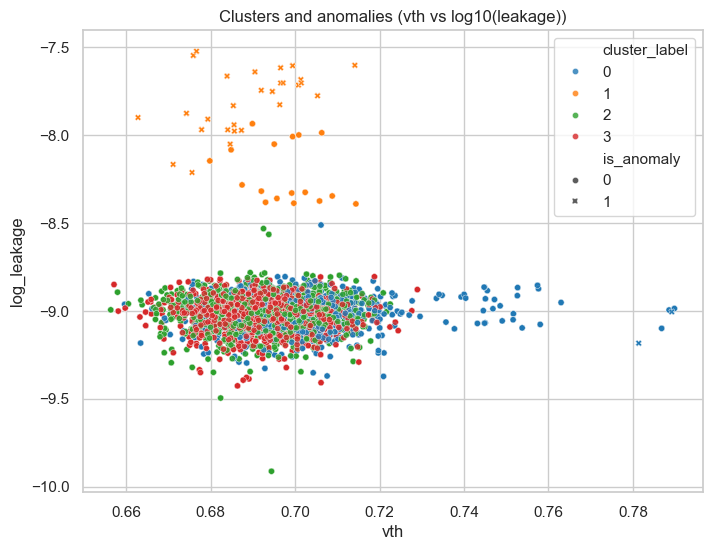

In [ ]:
import numpy as np
df_ml['log_leakage'] = np.log10(df_ml['leakage'].replace(0, np.nan))
plt.figure(figsize=(8,6))
sns.scatterplot(data=df_ml, x='vth', y='log_leakage', hue='cluster_label', style='is_anomaly', s=20, alpha=0.8, palette='tab10')
plt.title('Clusters and anomalies (vth vs log10(leakage))')
plt.show()


Counts and simple stats per wafer & cluster

In [ ]:
# anomalies per wafer
print("Anomalies per wafer:")
print(df_ml.groupby('wafer_id')['is_anomaly'].sum())

# anomalies per cluster
print("\nAnomalies per cluster:")
print(df_ml.groupby('cluster_label')['is_anomaly'].sum())

# cluster sizes
print("\nCluster sizes:")
print(df_ml['cluster_label'].value_counts().sort_index())


Anomalies per wafer:
wafer_id
3    12
4    45
5    33
Name: is_anomaly, dtype: int64

Anomalies per cluster:
cluster_label
0     6
1    84
2     0
3     0
Name: is_anomaly, dtype: int64

Cluster sizes:
cluster_label
0    2880
1     135
2    3390
3    2595
Name: count, dtype: int64


Evaluation cell

In [ ]:
# Evaluation: precision / recall / F1 + confusion matrix
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import pandas as pd

# engine already created by the discovery cell
df_true = pd.read_sql("SELECT wafer_id, device_name, is_defect, x, y FROM devices_sim", engine)
df_pred = pd.read_sql("SELECT wafer_id, device_name, is_anomaly, anomaly_score, x, y FROM devices_sim_ml", engine)

# merge on wafer_id + device_name + coords
df = df_true.merge(df_pred, on=['wafer_id','device_name','x','y'], how='left').fillna({'is_anomaly':0})
df['is_defect'] = df['is_defect'].astype(int)
df['is_anomaly'] = df['is_anomaly'].astype(int)

y_true = df['is_defect']
y_pred = df['is_anomaly']

print("Total rows:", len(df))
print("True defects:", int(y_true.sum()))
print("Predicted anomalies:", int(y_pred.sum()))

prec = precision_score(y_true, y_pred, zero_division=0)
rec = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)
cm = confusion_matrix(y_true, y_pred)

print(f"Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}")
print("Confusion matrix (rows=true 0/1, cols=pred 0/1):")
print(cm)

# per-wafer summary
print("\nPer-wafer summary (true_defects, predicted_anomalies):")
print(df.groupby('wafer_id').agg(true_defects=('is_defect','sum'), predicted_anomalies=('is_anomaly','sum')))


Total rows: 27000
True defects: 738
Predicted anomalies: 810
Precision: 0.800, Recall: 0.878, F1: 0.837
Confusion matrix (rows=true 0/1, cols=pred 0/1):
[[26100   162]
 [   90   648]]

Per-wafer summary (true_defects, predicted_anomalies):
          true_defects  predicted_anomalies
wafer_id                                   
3                  153                  189
4                  162                  225
5                  423                  396


In [ ]:
from pathlib import Path
print("Notebook CWD:", Path.cwd())
candidate = Path.cwd() / "src" / "wafer_data.db"
print("Trying:", candidate)
print("Exists?:", candidate.exists())
# also check the likely project-root path (one level up)
parent_candidate = Path.cwd().parent / "src" / "wafer_data.db"
print("Parent candidate:", parent_candidate, "Exists?:", parent_candidate.exists())


Notebook CWD: c:\Users\sahad\Desktop\wafer-ml-project\notebooks
Trying: c:\Users\sahad\Desktop\wafer-ml-project\notebooks\src\wafer_data.db
Exists?: False
Parent candidate: c:\Users\sahad\Desktop\wafer-ml-project\src\wafer_data.db Exists?: True


In [ ]:
from pathlib import Path
from sqlalchemy import create_engine
import pandas as pd

# search upward for src/wafer_data.db
p = Path.cwd()
DB_PATH = None
for _ in range(8):
    candidate = p / "src" / "wafer_data.db"
    if candidate.exists():
        DB_PATH = candidate.resolve()
        break
    p = p.parent

if DB_PATH is None:
    raise FileNotFoundError("could not find src/wafer_data.db in parent folders; check DB location or close any DB locks")

print("Using DB path:", DB_PATH)
engine = create_engine(f"sqlite:///{DB_PATH.as_posix()}")

# quick test read
print("Tables:", pd.read_sql("SELECT name FROM sqlite_master WHERE type='table'", engine))


Using DB path: C:\Users\sahad\Desktop\wafer-ml-project\src\wafer_data.db
Tables:               name
0           wafers
1          devices
2      devices_sim
3  devices_cleaned
4       devices_ml
5   devices_sim_ml


Save publication-quality PNGs

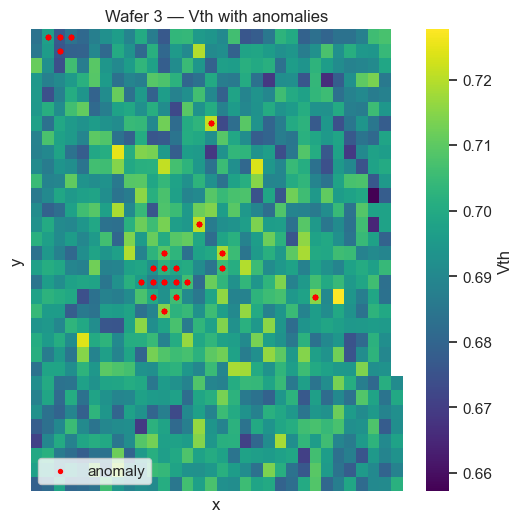

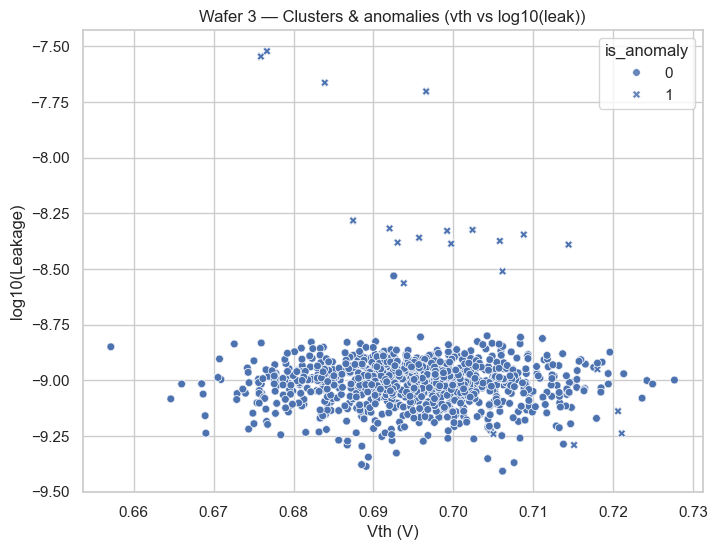

Saved figures to: c:\Users\sahad\Desktop\wafer-ml-project\src\figures\wafer_3_vth_anomalies.png c:\Users\sahad\Desktop\wafer-ml-project\src\figures\wafer_3_clusters.png
Columns in plotted DF: ['wafer_id', 'device_name', 'vth', 'leakage', 'x', 'y', 'is_defect_x', 'log_leakage', 'radial_dist', 'is_defect_y', 'is_anomaly', 'anomaly_score']


In [97]:
# Fix & re-draw plots (use this if previous plot failed with missing columns)
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

sns.set(style="whitegrid")

# locate DB engine (reuse existing engine if present; otherwise re-create)
try:
    engine
except NameError:
    from sqlalchemy import create_engine
    from pathlib import Path
    # robust discovery for DB path
    p = Path.cwd()
    DB_PATH = None
    for _ in range(8):
        cand = p / "src" / "wafer_data.db"
        if cand.exists():
            DB_PATH = cand.resolve()
            break
        p = p.parent
    if DB_PATH is None:
        raise FileNotFoundError("Could not find src/wafer_data.db")
    engine = create_engine(f"sqlite:///{DB_PATH.as_posix()}")

# load merged tables (prefer devices_sim_ml if it exists)
df_sim = pd.read_sql("SELECT * FROM devices_sim", engine)
# try devices_sim_ml; if missing, try devices_sim + devices_ml merge
try:
    df_ml = pd.read_sql("SELECT * FROM devices_sim_ml", engine)
except Exception:
    try:
        df_ml = pd.read_sql("SELECT * FROM devices_ml", engine)
    except Exception:
        df_ml = None

# Merge so we have cluster_label and is_anomaly in one DataFrame
if df_ml is not None:
    # some tables may have different column names; ensure keys exist
    merge_cols = ['wafer_id','device_name','x','y','vth','leakage']
    common = [c for c in merge_cols if c in df_sim.columns and c in df_ml.columns]
    df = df_sim.merge(df_ml, on=common, how='left')
else:
    df = df_sim.copy()
    # If cluster_label isn't present, create a simple default
    if 'cluster_label' not in df.columns:
        df['cluster_label'] = 0
    if 'is_anomaly' not in df.columns:
        df['is_anomaly'] = 0

# ensure log_leakage exists
df['leakage'] = pd.to_numeric(df['leakage'], errors='coerce')
df = df.dropna(subset=['leakage'])
df['log_leakage'] = np.log10(df['leakage'].replace(0, np.nan))

# ensure cluster_label and is_anomaly types
if 'cluster_label' in df.columns:
    df['cluster_label'] = df['cluster_label'].astype(int)
if 'is_anomaly' in df.columns:
    df['is_anomaly'] = df['is_anomaly'].fillna(0).astype(int)
else:
    df['is_anomaly'] = 0

# choose wafer to plot (first wafer)
first_wid = df['wafer_id'].unique()[0]
g = df[df['wafer_id']==first_wid].copy()

# ensure figures saved to project-root/src/figures (not notebooks/src/...)
project_root = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
out_dir = project_root / "src" / "figures"
out_dir.mkdir(parents=True, exist_ok=True)

# 1) Vth heatmap with anomaly overlay
pivot = g.pivot_table(index='y', columns='x', values='vth', aggfunc='mean')
plt.figure(figsize=(6,6))
sns.heatmap(pivot[::-1], cmap='viridis', cbar_kws={'label':'Vth'}, xticklabels=False, yticklabels=False)
anom = g[g['is_anomaly']==1]
if not anom.empty:
    ax = plt.gca()
    ax.scatter(anom['x']+0.5, pivot.shape[0]-1 - anom['y']+0.5, c='red', s=8, label='anomaly')
    ax.legend(loc='lower left')
plt.title(f"Wafer {first_wid} — Vth with anomalies")
png1 = out_dir / f"wafer_{first_wid}_vth_anomalies.png"
plt.savefig(png1, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

# 2) Cluster scatter (vth vs log_leakage) colored by cluster, anomaly style
# If cluster_label is all zeros, seaborn will still plot it
plt.figure(figsize=(8,6))
if 'cluster_label' in g.columns:
    sns.scatterplot(data=g, x='vth', y='log_leakage', hue='cluster_label', style='is_anomaly', s=30, palette='tab10', alpha=0.85)
else:
    sns.scatterplot(data=g, x='vth', y='log_leakage', style='is_anomaly', s=30, alpha=0.85)
plt.title(f"Wafer {first_wid} — Clusters & anomalies (vth vs log10(leak))")
plt.xlabel('Vth (V)')
plt.ylabel('log10(Leakage)')
png2 = out_dir / f"wafer_{first_wid}_clusters.png"
plt.savefig(png2, bbox_inches='tight', dpi=300)
plt.show()
plt.close()

print("Saved figures to:", png1, png2)
print("Columns in plotted DF:", g.columns.tolist())


c=0.005  prec=1.000  rec=0.183  f1=0.309  preds=45
c=0.010  prec=0.967  rec=0.354  f1=0.518  preds=90
c=0.020  prec=0.917  rec=0.671  f1=0.775  preds=180
c=0.030  prec=0.800  rec=0.878  f1=0.837  preds=270
c=0.050  prec=0.540  rec=0.988  f1=0.698  preds=450
c=0.080  prec=0.342  rec=1.000  f1=0.509  preds=720


,contamination,precision,recall,f1,pred_count
0,0.005,1.000000,0.182927,0.309278,45
1,0.010,0.966667,0.353659,0.517857,90
2,0.020,0.916667,0.670732,0.774648,180
3,0.030,0.800000,0.878049,0.837209,270
4,0.050,0.540000,0.987805,0.698276,450
5,0.080,0.341667,1.000000,0.509317,720


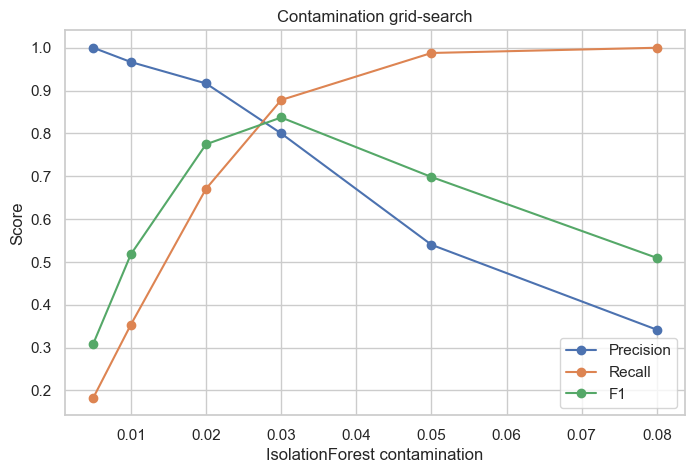


Best by F1: {'contamination': 0.03, 'precision': 0.8, 'recall': 0.8780487804878049, 'f1': 0.8372093023255814, 'pred_count': 270.0}
Wrote devices_sim_ml with contamination=0.03


In [94]:
# Grid-search over contamination for IsolationForest
# Run after discovery cell which sets `engine`
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score

sns.set(style="whitegrid")

# Load simulated data (truth)
df_sim = pd.read_sql("SELECT * FROM devices_sim", engine)
# prepare dataset
df = df_sim.copy()
df['vth'] = pd.to_numeric(df['vth'], errors='coerce')
df['leakage'] = pd.to_numeric(df['leakage'], errors='coerce')
df = df.dropna(subset=['vth','leakage']).reset_index(drop=True)
df = df[df['leakage'] > 0]
df['log_leakage'] = np.log10(df['leakage'])
# radial feature
if {'x','y'}.issubset(df.columns):
    xm, ym = df['x'].mean(), df['y'].mean()
    df['radial_dist'] = np.sqrt((df['x']-xm)**2 + (df['y']-ym)**2)
else:
    df['radial_dist'] = 0.0

features = ['vth','log_leakage','radial_dist']
X_raw = df[features].values
scaler = StandardScaler()
X = scaler.fit_transform(X_raw)

contaminations = [0.005, 0.01, 0.02, 0.03, 0.05, 0.08]   # try a range
results = []

for c in contaminations:
    iso = IsolationForest(n_estimators=200, contamination=c, random_state=42)
    preds = iso.fit_predict(X)    # -1 anomaly, 1 normal
    y_pred = (preds == -1).astype(int)
    y_true = df['is_defect'].astype(int) if 'is_defect' in df.columns else pd.Series(np.zeros(len(df), dtype=int))
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    results.append({'contamination': c, 'precision': prec, 'recall': rec, 'f1': f1, 'pred_count': int(y_pred.sum())})
    print(f"c={c:.3f}  prec={prec:.3f}  rec={rec:.3f}  f1={f1:.3f}  preds={int(y_pred.sum())}")

# Dataframe and plot
res_df = pd.DataFrame(results)
display(res_df)

plt.figure(figsize=(8,5))
plt.plot(res_df['contamination'], res_df['precision'], marker='o', label='Precision')
plt.plot(res_df['contamination'], res_df['recall'], marker='o', label='Recall')
plt.plot(res_df['contamination'], res_df['f1'], marker='o', label='F1')
plt.xlabel('IsolationForest contamination')
plt.ylabel('Score')
plt.title('Contamination grid-search')
plt.legend()
plt.grid(True)
plt.show()

# Save the best contamination by F1
best = res_df.loc[res_df['f1'].idxmax()]
print("\nBest by F1:", best.to_dict())

# Optionally: write the predictions for the chosen contamination back to DB for visualization
chosen = float(best['contamination'])  # or set manually e.g. chosen = 0.03
iso = IsolationForest(n_estimators=200, contamination=chosen, random_state=42)
y_pred = (iso.fit_predict(X) == -1).astype(int)
df_out = df.copy()
df_out['is_anomaly'] = y_pred
df_out['anomaly_score'] = iso.decision_function(X)
# overwrite devices_sim_ml table
df_out[['wafer_id','device_name','x','y','vth','leakage','log_leakage','radial_dist','is_defect','is_anomaly','anomaly_score']].to_sql('devices_sim_ml', engine, if_exists='replace', index=False)
print(f"Wrote devices_sim_ml with contamination={chosen}")
